# Index

 * [Importing stuff](#importing) 
 * [Data scraping and cleaning](#scraping)
 * [Getting Venues data](#getting_venues)
 * [Checkpoint](#checkpoint_1)
 * [Clustering](#clustering)
 * [Likes scraping](#likes)
 * [Likes WIP](#likes)


<a id='importing'></a>

# Importing everything we need

In [1]:
import pandas as pd
import numpy as np
import bs4 as bs
import requests
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium=0.5.0 --yes
import folium
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics
import seaborn as sns

<a id='scraping'></a>

# Data Scraping and cleaning
## Getting data about the neighborhoods such as name and location

This section scrapes data about the neighborhoods in Belo Horizonte from a Wikipedia page. In this page we find the name of the neighborhood, its population and size in km²

In [72]:
url = 'https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Belo_Horizonte'
WikiBH = requests.get(url).content
soup = bs.BeautifulSoup(WikiBH,'html.parser')     

In [73]:
data = []
for item in range(len(soup.find_all('tbody')[3].find_all('tr'))):
    row=[]
    if item >0:
        for row_item in range(len(soup.find_all('tbody')[3].find_all('tr')[1].find_all('td'))):
            row.append(soup.find_all('tbody')[3].find_all('tr')[item].find_all('td')[row_item].get_text())
    data.append(row)

df = pd.DataFrame(data,columns=['#','Zone','Regional','Neighborhood','Population','Size(km²)'])
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)
df

,#,Zone,Regional,Neighborhood,Population,Size(km²)
0,1,ZONA LESTE,Leste,Sagrada Família,34 395,"2,291\n"
1,2,ZONA SUL,Oeste,Buritis,29 374,"3,823\n"
2,3,ZONA OESTE,Noroeste,Padre Eustáquio,28 773,"2,969\n"
3,4,ZONA OESTE,Barreiro,Lindéia,25 231,"2,012\n"
4,5,ZONA NORTE,Pamp./ Venda Nova,Santa Mônica,23 883,"2,178\n"
...,...,...,...,...,...,...
498,483,ZONA LESTE,Nordeste,Guanabara,0,"0,002\n"
499,484,ZONA NORTE,Pampulha,Lagoa da Pampulha,0,"3,138\n"
500,485,ZONA NORTE,Noroeste,Sumaré,0,"0,149\n"
501,486,ZONA LESTE,Leste,Vila Vera Cruz I,0,"0,008\n"


In [74]:
df['latitude']=0.0
df['longitude']=0.0
for i in range(len(df['Neighborhood'])):
    address = df['Neighborhood'][i] +', Belo Horizonte'                                
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    if location != None:
        latitude = location.latitude
        longitude = location.longitude
        print('The geograpical coordinate of {} are {}, {}.  {}'.format(address,latitude, longitude,i))
        df['latitude'][i]=latitude
        df['longitude'][i]=longitude
    else:
        print(df['Neighborhood'][i] + ' wasn\'t found on Nominatim')
        df['latitude'][i]=''
        df['longitude'][i]=''

The geograpical coordinate of Sagrada Família, Belo Horizonte are -19.9003321, -43.9237228.  0


<ipython-input-74-123152a0de33>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latitude'][i]=latitude
<ipython-input-74-123152a0de33>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['longitude'][i]=longitude


The geograpical coordinate of Buritis, Belo Horizonte are -19.9765791, -43.9674165.  1
The geograpical coordinate of Padre Eustáquio, Belo Horizonte are -19.9143045, -43.97935599013762.  2
The geograpical coordinate of Lindéia, Belo Horizonte are -19.9774137, -44.0506354.  3
The geograpical coordinate of Santa Mônica, Belo Horizonte are -19.8245686, -43.977456.  4
The geograpical coordinate of Céu Azul, Belo Horizonte are -19.8227499, -44.0039799.  5
The geograpical coordinate of Santa Cruz (ZN), Belo Horizonte are -19.8790013, -43.9411052.  6
The geograpical coordinate of Santa Cruz (ZL), Belo Horizonte are -19.8790013, -43.9411052.  7
The geograpical coordinate of Santo Antônio, Belo Horizonte are -19.9439258, -43.9451366.  8
The geograpical coordinate of Alto Vera Cruz, Belo Horizonte are -19.9110402, -43.8915918.  9
The geograpical coordinate of Jardim dos Comerciários, Belo Horizonte are -19.7927251, -43.9720853.  10
The geograpical coordinate of Piratininga, Belo Horizonte are -1

The geograpical coordinate of Itapoã, Belo Horizonte are -19.8385689, -43.9554151.  89
The geograpical coordinate of Jardim Leblon, Belo Horizonte are -19.8236179, -43.9913595.  90
The geograpical coordinate of Cachoeirinha, Belo Horizonte are -19.8902003, -43.9474556.  91
The geograpical coordinate of Bairro das Indústrias I, Belo Horizonte are -19.963364, -44.0029681.  92
The geograpical coordinate of Santa Inês, Belo Horizonte are -19.8903311, -43.9096812.  93
The geograpical coordinate of Lagoa, Belo Horizonte are -19.8088758, -44.0001975.  94
The geograpical coordinate of São Bernardo, Belo Horizonte are -19.8449229, -43.941626.  95
The geograpical coordinate of Renascença, Belo Horizonte are -19.8912995, -43.9417132.  96
The geograpical coordinate of Dona Clara, Belo Horizonte are -19.859062, -43.942463.  97
The geograpical coordinate of Funcionários, Belo Horizonte are -19.932516200000002, -43.92731827346328.  98
The geograpical coordinate of Belvedere, Belo Horizonte are -19.97

<ipython-input-74-123152a0de33>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['latitude'][i]=''
C:\Users\lucas\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-74-123152a0de33>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['longitude'][i]=''


The geograpical coordinate of Horto Florestal, Belo Horizonte are -19.89546035, -43.91695737553633.  156
The geograpical coordinate of Jardim Montanhês, Belo Horizonte are -19.9051254, -43.9821385.  157
The geograpical coordinate of Juliana, Belo Horizonte are -19.8151, -43.9439193.  158
The geograpical coordinate of São Salvador, Belo Horizonte are -19.8939304, -44.0133336.  159
The geograpical coordinate of Coração de Jesus, Belo Horizonte are -19.945874099999997, -43.95122862577084.  160
The geograpical coordinate of Silveira, Belo Horizonte are -19.8917944, -43.9299132.  161
The geograpical coordinate of Olaria, Belo Horizonte are -19.9908908, -44.0277945.  162
The geograpical coordinate of Pompéia, Belo Horizonte are -19.9096481, -43.9024279.  163
The geograpical coordinate of Vila CEMIG, Belo Horizonte are -19.995432800000003, -43.992366573805114.  164
The geograpical coordinate of Nova Cintra, Belo Horizonte are -19.9480576, -43.9900717.  165
The geograpical coordinate of Castan

The geograpical coordinate of Barroca, Belo Horizonte are -19.931433, -43.9635526.  242
The geograpical coordinate of Dom Joaquim, Belo Horizonte are -19.8781302, -43.9188798.  243
The geograpical coordinate of Pirajá, Belo Horizonte are -19.8659435, -43.9170773.  244
The geograpical coordinate of Conjunto Paulo VI, Belo Horizonte are -19.8314739, -43.8865391138505.  245
The geograpical coordinate of Alto dos Pinheiros, Belo Horizonte are -19.9325674, -44.004875.  246
The geograpical coordinate of Parque São José, Belo Horizonte are -19.9625893, -43.9779282.  247
The geograpical coordinate of Vila Califórnia, Belo Horizonte are -19.9189875, -44.00829.  248
The geograpical coordinate of Novo Tupi, Belo Horizonte are -19.8306232, -43.9048449.  249
The geograpical coordinate of Vila Independência I, Belo Horizonte are -20.01865705, -44.03085365009295.  250
The geograpical coordinate of Conjunto Jardim Filadélfia, Belo Horizonte are -19.9107907, -44.007685.  251
The geograpical coordinate 

The geograpical coordinate of Estrela, Belo Horizonte are -19.9496464, -43.94047506881119.  326
The geograpical coordinate of Vila Átila de Paiva, Belo Horizonte are -19.97934125, -44.03161219408935.  327
The geograpical coordinate of Olhos d'água, Belo Horizonte are -19.9900458, -43.9631249.  328
The geograpical coordinate of Vila Coqueiral, Belo Horizonte are -19.9152291, -44.0247224.  329
The geograpical coordinate of Cidade Jardim, Belo Horizonte are -19.9413641, -43.9515493.  330
The geograpical coordinate of Vila Trinta e Um de Março, Belo Horizonte are -19.9204149, -44.0009698.  331
The geograpical coordinate of São José, Belo Horizonte are -19.8602115, -43.9656973.  332
The geograpical coordinate of Solimões, Belo Horizonte are -19.82183215, -43.92672153166126.  333
The geograpical coordinate of Bernadete, Belo Horizonte are -19.985184099999998, -43.98424361198627.  334
The geograpical coordinate of Xodó-Marize, Belo Horizonte are -19.821801649999998, -43.94017477200708.  335
T

The geograpical coordinate of São Vicente, Belo Horizonte are -19.36458795, -43.931034820028295.  410
The geograpical coordinate of Novo Ouro Preto, Belo Horizonte are -19.8841449, -43.9843336.  411
The geograpical coordinate of Canadá, Belo Horizonte are -19.896521200000002, -43.94491367052375.  412
Antônio Ribeiro de Abreu wasn't found on Nominatim
The geograpical coordinate of Satélite, Belo Horizonte are -19.8129804, -43.9481047.  414
The geograpical coordinate of Vila Antena Montanhês, Belo Horizonte are -19.8963971, -43.9859864.  415
The geograpical coordinate of Grotinha, Belo Horizonte are -19.85051765, -43.89231111805725.  416
The geograpical coordinate of Cônego Pinheiro, Belo Horizonte are -19.91902745, -43.90939312565658.  417
The geograpical coordinate of Chácara Leonina, Belo Horizonte are -19.954873749999997, -43.96042496060794.  418
The geograpical coordinate of Vila Madre Gertrudes III, Belo Horizonte are -19.9538321, -44.00595520540928.  419
The geograpical coordinate

The geograpical coordinate of Xangri-lá, Belo Horizonte are -19.8381043, -44.0181543.  494
The geograpical coordinate of Belém, Belo Horizonte are -19.9196499, -44.0982973.  495
The geograpical coordinate of Bispo de Maura, Belo Horizonte are -19.826981699999997, -44.01314460674691.  496
The geograpical coordinate of Campus UFMG, Belo Horizonte are -19.8679746, -43.9644274.  497
The geograpical coordinate of Guanabara, Belo Horizonte are -19.9701771, -44.1376229.  498
The geograpical coordinate of Lagoa da Pampulha, Belo Horizonte are -19.8533828, -43.97478514927906.  499
The geograpical coordinate of Sumaré, Belo Horizonte are -19.8875873, -43.9654843.  500
The geograpical coordinate of Vila Vera Cruz I, Belo Horizonte are -20.4536873, -54.6623499.  501
Vila Vera Cruz II wasn't found on Nominatim


In [76]:
df.drop(df[df['latitude']==''].index,inplace=True)
df.reset_index(drop=True,inplace=True)
df

,#,Zone,Regional,Neighborhood,Population,Size(km²),latitude,longitude
0,1,ZONA LESTE,Leste,Sagrada Família,34 395,"2,291\n",-19.9003,-43.9237
1,2,ZONA SUL,Oeste,Buritis,29 374,"3,823\n",-19.9766,-43.9674
2,3,ZONA OESTE,Noroeste,Padre Eustáquio,28 773,"2,969\n",-19.9143,-43.9794
3,4,ZONA OESTE,Barreiro,Lindéia,25 231,"2,012\n",-19.9774,-44.0506
4,5,ZONA NORTE,Pamp./ Venda Nova,Santa Mônica,23 883,"2,178\n",-19.8246,-43.9775
...,...,...,...,...,...,...,...,...
485,482,ZONA NORTE,Pampulha,Campus UFMG,0,"3,85\n",-19.868,-43.9644
486,483,ZONA LESTE,Nordeste,Guanabara,0,"0,002\n",-19.9702,-44.1376
487,484,ZONA NORTE,Pampulha,Lagoa da Pampulha,0,"3,138\n",-19.8534,-43.9748
488,485,ZONA NORTE,Noroeste,Sumaré,0,"0,149\n",-19.8876,-43.9655


In [81]:
# create map of Belo Horizonte using latitude and longitude values
address = 'Belo Horizonte, MG'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_BH = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['latitude'], df['longitude'], df['Zone'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_BH)  
    
map_BH

In [78]:
# Cleaning the data to remove points outside of the city
df = df[(df['longitude'].astype(float)<-43.85) & (df['longitude'].astype(float)>-44.07)
 & (df['latitude'].astype(float)<-19.82) & (df['latitude'].astype(float)>-20) ].reset_index(drop=True,inplace=True)
#Saving to a csv file to make my life easier. If needed I can open the df from the file instead of srapping everything again
#df.to_csv('BH_df.csv')

In [79]:
df

<a id='getting_venues'></a>

# Getting data about venues on Foursquare

This section get data about all venues registered to Foursquare. This will be used to cluster the neighborhoods and find the ones most similar to Buritis

In [2]:
CLIENT_ID = 'UOSOUPHZSZ31RZYIACFNWILJ4U1E4HJPT51BGJEXQUKCUJSW' # your Foursquare ID
CLIENT_SECRET = 'ZRXAYW4AVLVJAOAOQP3QS2M1CLFUF5SGCLB5GUQYAM10R2MG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: UOSOUPHZSZ31RZYIACFNWILJ4U1E4HJPT51BGJEXQUKCUJSW
CLIENT_SECRET:ZRXAYW4AVLVJAOAOQP3QS2M1CLFUF5SGCLB5GUQYAM10R2MG


In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            #print(results)
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng,
                v['venue']['name'],
                v['venue']['id'],
                #requests.get('https://api.foursquare.com/v2/venues/{}/?client_id={}&client_secret={}&v={}'.format(v['venue']['id'], CLIENT_ID, CLIENT_SECRET, VERSION)).json()['response']['venue']['likes']['count'],
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            print(venues_list)
            nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
            nearby_venues.columns = ['Neighborhood', 
                                     'Neighborhood Latitude', 
                                     'Neighborhood Longitude', 
                                     'Venue',
                                     'Venue id',
                                     #'Venue likes',
                                     'Venue Latitude', 
                                     'Venue Longitude', 
                                     'Venue Category']
        except:
            print(requests.get(url).json()['meta']['errorType'])
            return(nearby_venues) 
   
    return(nearby_venues)

In [ ]:
BH_venues = getNearbyVenues(names=df['Neighborhood'],latitudes=df['latitude'],longitudes=df['longitude'])
BH_venues

In [ ]:
BH_venues.to_csv('BH_venues.csv')

<a id='checkpoint_1'></a>

# Checkpoint to make my life easier

In [3]:
# Read from csv so I don't have to scrape everything. Had trouble with the Foursquare limit while developing some functions
df = pd.read_csv('BH_df.csv')
BH_venues = pd.read_csv('BH_venues.csv')
similar_hood = pd.read_csv('PetStore.csv')

<a id='clustering'></a>

# Clustering

In this, the neighborhoods will be analysed and clustered based on venue frequency

In [4]:
# one hot encoding
BH_onehot = pd.get_dummies(BH_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
BH_onehot['Neighborhood'] = BH_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [BH_onehot.columns[-1]] + list(BH_onehot.columns[:-1])
BH_onehot = BH_onehot[fixed_columns]

BH_onehot

,Yoga Studio,ATM,Acai House,Accessories Store,Airport Lounge,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,...,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7858,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7859,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7860,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
BH_grouped = BH_onehot.groupby('Neighborhood').mean().reset_index()
BH_grouped

,Neighborhood,Yoga Studio,ATM,Acai House,Accessories Store,Airport Lounge,Amphitheater,Antique Shop,Arcade,Arepa Restaurant,...,Video Game Store,Video Store,Volleyball Court,Warehouse Store,Watch Shop,Water Park,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,Aarão Reis,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,Acaba Mundo,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2,Acaiaca,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
3,Ademar Maldonado,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
4,Aeroporto,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,Xangri-lá,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
360,Xodó-Marize,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
361,Álvaro Camargos,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.166667
362,Ápia,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [6]:
fixed_columns = [BH_onehot.columns[-1]] + list(BH_onehot.columns[:-1])
BH_onehot = BH_onehot[fixed_columns]

In [7]:
num_top_venues = 5

for hood in BH_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = BH_grouped[BH_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aarão Reis----
            venue  freq
0             Bar  0.10
1  Ice Cream Shop  0.10
2          Bakery  0.10
3        Pharmacy  0.05
4    Burger Joint  0.05


----Acaba Mundo----
                     venue  freq
0                    Plaza  0.33
1               Food Truck  0.17
2              Snack Place  0.17
3  Comfort Food Restaurant  0.17
4               Racecourse  0.17


----Acaiaca----
         venue  freq
0  Pizza Place  0.14
1       Bakery  0.09
2    Juice Bar  0.09
3     Pharmacy  0.09
4    Pet Store  0.05


----Ademar Maldonado----
                  venue  freq
0                 Plaza  0.14
1                   Bar  0.14
2                Bakery  0.10
3      Sushi Restaurant  0.10
4  Fast Food Restaurant  0.10


----Aeroporto----
                  venue  freq
0                Office  0.33
1              Boutique  0.17
2  Gym / Fitness Center  0.17
3            Water Park  0.17
4            Food Truck  0.17


----Alpes----
                  venue  freq
0           Snack Pl

4        Pharmacy  0.04


----Colégio Batista (HC)----
                  venue  freq
0                Bakery  0.09
1  Brazilian Restaurant  0.09
2           Supermarket  0.06
3                 Plaza  0.06
4                   Bar  0.06


----Colégio Batista (ZL)----
                  venue  freq
0                Bakery  0.09
1  Brazilian Restaurant  0.09
2           Supermarket  0.06
3                 Plaza  0.06
4                   Bar  0.06


----Comiteco----
            venue  freq
0  Cosmetics Shop  0.12
1    Burger Joint  0.06
2  Chocolate Shop  0.06
3             Gym  0.06
4           Track  0.06


----Concórdia----
                  venue  freq
0         Grocery Store  0.18
1  Brazilian Restaurant  0.09
2                Bakery  0.09
3      Toy / Game Store  0.09
4              Bus Stop  0.09


----Confisco----
                     venue  freq
0                   Bakery  0.17
1  Health & Beauty Service  0.11
2           Ice Cream Shop  0.11
3     Brazilian Restaurant  0.06
4      

                     venue  freq
0  Fruit & Vegetable Store  0.12
1             Burger Joint  0.12
2                   Bakery  0.08
3           Ice Cream Shop  0.08
4     Gym / Fitness Center  0.08


----Jardim Guanabara----
                    venue  freq
0                  Bakery  0.19
1  Furniture / Home Store  0.07
2                Pharmacy  0.07
3             Supermarket  0.07
4               Pet Store  0.07


----Jardim Leblon----
                  venue  freq
0                Bakery  0.15
1  Gym / Fitness Center  0.15
2         Hot Dog Joint  0.08
3  Brazilian Restaurant  0.08
4                  Park  0.08


----Jardim Montanhês----
          venue  freq
0    Restaurant  0.10
1  Burger Joint  0.06
2           Gym  0.06
3        Bakery  0.06
4       Stadium  0.03


----Jardim São José----
                venue  freq
0       Grocery Store  0.18
1  Athletics & Sports  0.18
2        Burger Joint  0.09
3              Bakery  0.09
4         Bus Station  0.09


----Jardim Vitória----
 

4  Soccer Field  0.07


----Paraíso----
                  venue  freq
0                Bakery  0.20
1  Brazilian Restaurant  0.12
2               Brewery  0.08
3         Grocery Store  0.08
4           Snack Place  0.08


----Parque São José----
                  venue  freq
0            Steakhouse   0.1
1              Bus Stop   0.1
2  Gym / Fitness Center   0.1
3         Historic Site   0.1
4           Flower Shop   0.1


----Paulo VI----
                     venue  freq
0           Ice Cream Shop  0.25
1  Fruit & Vegetable Store  0.12
2               Food Truck  0.12
3                 Pharmacy  0.12
4                      Bar  0.12


----Pedreira Prado Lopes----
                  venue  freq
0  Brazilian Restaurant  0.11
1          Liquor Store  0.11
2             Bookstore  0.11
3           Supermarket  0.11
4              Bus Stop  0.11


----Penha----
                  venue  freq
0  Brazilian Restaurant  0.10
1                   Bar  0.10
2  Gym / Fitness Center  0.10
3        I

                           venue  freq
0                     Food Truck  0.14
1                         Bakery  0.14
2                    Supermarket  0.07
3                         Buffet  0.07
4  Paper / Office Supplies Store  0.07


----Vila Calafate----
                  venue  freq
0                Bakery  0.13
1             Juice Bar  0.07
2              Pharmacy  0.07
3            Steakhouse  0.07
4  Brazilian Restaurant  0.07


----Vila Califórnia----
           venue  freq
0    Auto Garage  0.09
1      Pet Store  0.09
2            Bar  0.09
3         Bakery  0.09
4  Women's Store  0.05


----Vila Canto do Sabiá----
             venue  freq
0           Bakery  0.25
1   Ice Cream Shop  0.25
2     Soccer Field  0.25
3            Motel  0.25
4  Other Nightlife  0.00


----Vila Clóris----
                  venue  freq
0  Brazilian Restaurant  0.05
1           Coffee Shop  0.05
2  Fast Food Restaurant  0.05
3      Toy / Game Store  0.04
4        Clothing Store  0.04


----Vila Copac

                  venue  freq
0  Gym / Fitness Center  0.08
1                   Bar  0.06
2                   Gym  0.06
3  Brazilian Restaurant  0.06
4         Shopping Mall  0.06


----Vila Pilar----
           venue  freq
0  Big Box Store  0.14
1    Pizza Place  0.14
2         Buffet  0.14
3    Snack Place  0.14
4     Restaurant  0.14


----Vila Piratininga----
                  venue  freq
0                Bakery  0.11
1  Gym / Fitness Center  0.11
2             Pet Store  0.11
3        Ice Cream Shop  0.11
4            Restaurant  0.11


----Vila Primeiro de Maio----
                  venue  freq
0           Snack Place  0.15
1                Bakery  0.08
2           Supermarket  0.08
3            Sports Bar  0.08
4  Fast Food Restaurant  0.08


----Vila Real I----
             venue  freq
0             Farm   0.5
1     Burger Joint   0.5
2  Other Nightlife   0.0
3      Pastry Shop   0.0
4       Pastelaria   0.0


----Vila Real II----
             venue  freq
0             Farm   0

In [8]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = BH_grouped['Neighborhood']

for ind in np.arange(BH_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(BH_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aarão Reis,Ice Cream Shop,Bar,Bakery,Burger Joint,Pub,Park,Gym,Gym / Fitness Center,Supermarket,Restaurant
1,Acaba Mundo,Plaza,Racecourse,Food Truck,Comfort Food Restaurant,Snack Place,Women's Store,Fast Food Restaurant,Event Space,Fair,Farm
2,Acaiaca,Pizza Place,Bakery,Pharmacy,Juice Bar,IT Services,Gym / Fitness Center,Motorcycle Shop,Soccer Field,Snack Place,Fruit & Vegetable Store
3,Ademar Maldonado,Plaza,Bar,Bakery,Fast Food Restaurant,Sushi Restaurant,Ice Cream Shop,Pizza Place,Pet Store,Paper / Office Supplies Store,Soccer Field
4,Aeroporto,Office,Boutique,Food Truck,Water Park,Gym / Fitness Center,Event Space,Fair,Farm,Farmers Market,Fast Food Restaurant


In [22]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)

BH_grouped_clustering = BH_grouped.drop('Neighborhood', 1)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(BH_grouped_clustering)
    kmeanModel.fit(BH_grouped_clustering)
 
    distortions.append(sum(np.min(cdist(BH_grouped_clustering, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / BH_grouped_clustering.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(BH_grouped_clustering, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / BH_grouped_clustering.shape[0]
    mapping2[k] = kmeanModel.inertia_

C:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\lucas\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [23]:
for key, val in mapping1.items():
    print(f'{key} : {val}')

1 : 0.2683079083749537
2 : 0.2606617741389766
3 : 0.25736100878355966
4 : 0.2526136447996752
5 : 0.25025267624620645
6 : 0.2482161759301631
7 : 0.24611163928241012
8 : 0.2429538807019166
9 : 0.24116880803491914


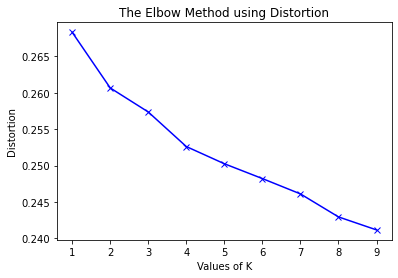

In [24]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

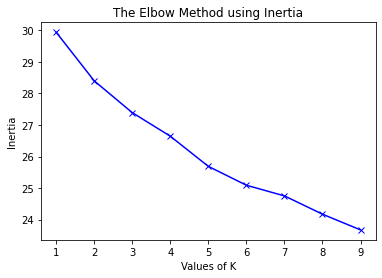

In [25]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [26]:
# set number of clusters
kclusters = 5

BH_grouped_clustering = BH_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(BH_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 4, 1, 4, 4, 4, 1, 4])

In [27]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_.astype(int))

BH_merged = df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
BH_merged = BH_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

BH_merged.head() # check the last columns!

,Unnamed: 0,#,Zone,Regional,Neighborhood,Population,Size(km²),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,2,ZONA SUL,Oeste,Buritis,29 374,"3,823\n",-19.976579,-43.967416,1.0,Gym / Fitness Center,Pharmacy,Pet Store,Park,Ice Cream Shop,Fruit & Vegetable Store,Fast Food Restaurant,Supermarket,Scenic Lookout,Lottery Retailer
1,1,3,ZONA OESTE,Noroeste,Padre Eustáquio,28 773,"2,969\n",-19.914305,-43.979356,2.0,Brazilian Restaurant,Pizza Place,Paper / Office Supplies Store,Bar,Soccer Field,Gym / Fitness Center,Ice Cream Shop,Pharmacy,Restaurant,Acai House
2,2,4,ZONA OESTE,Barreiro,Lindéia,25 231,"2,012\n",-19.977414,-44.050635,0.0,Bakery,Pharmacy,Clothing Store,Burger Joint,Supermarket,Women's Store,BBQ Joint,Plaza,Department Store,Pizza Place
3,3,5,ZONA NORTE,Pamp./ Venda Nova,Santa Mônica,23 883,"2,178\n",-19.824569,-43.977456,4.0,Burger Joint,Bar,Plaza,Brazilian Restaurant,Hot Dog Joint,Pastry Shop,Boutique,Soccer Field,Snack Place,Fish Market
4,4,6,ZONA NORTE,Pampulha,Céu Azul,23 817,"2,748\n",-19.822750,-44.003980,0.0,Bakery,Soccer Field,Food Truck,Pizza Place,Music Store,Spa,Pet Store,Health & Beauty Service,Grocery Store,Dessert Shop


In [28]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(BH_merged['latitude'], BH_merged['longitude'], BH_merged['Neighborhood'], BH_merged[BH_merged['Cluster Labels']<=4]['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [29]:
BH_merged.groupby('Cluster Labels').count()

,Unnamed: 0,#,Zone,Regional,Neighborhood,Population,Size(km²),latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,,,,,,,,,,
0.0,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85,85
1.0,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166,166
2.0,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42,42
3.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4.0,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70,70


In [30]:
BH_merged.loc[BH_merged['Cluster Labels'] == 0, BH_merged.columns[[4] + list(range(6, BH_merged.shape[1]))]]

,Neighborhood,Size(km²),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Lindéia,"2,012\n",-19.977414,-44.050635,0.0,Bakery,Pharmacy,Clothing Store,Burger Joint,Supermarket,Women's Store,BBQ Joint,Plaza,Department Store,Pizza Place
4,Céu Azul,"2,748\n",-19.822750,-44.003980,0.0,Bakery,Soccer Field,Food Truck,Pizza Place,Music Store,Spa,Pet Store,Health & Beauty Service,Grocery Store,Dessert Shop
23,Estrela Dalva,"0,92\n",-19.863977,-44.024623,0.0,Bakery,Ice Cream Shop,Pharmacy,Fruit & Vegetable Store,Lottery Retailer,Plaza,Pizza Place,Diner,Snack Place,Flower Shop
24,Havaí,"0,657\n",-19.954718,-43.974909,0.0,Bakery,Brazilian Restaurant,Paper / Office Supplies Store,Bus Station,Tourist Information Center,Basketball Court,Sandwich Place,Bus Stop,Snack Place,Record Shop
26,Conjunto Taquaril,"1,099\n",-19.919044,-43.878188,0.0,Furniture / Home Store,Construction & Landscaping,Snack Place,Grocery Store,Restaurant,Bakery,Bookstore,Food & Drink Shop,Food,Flower Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,Vila São Geraldo,"0,005\n",-19.895858,-43.898921,0.0,Bakery,Ice Cream Shop,Pizza Place,Pharmacy,Supermarket,Gym / Fitness Center,Plaza,Electronics Store,Taco Place,Market
346,Vila Canto do Sabiá,"0,017\n",-19.824621,-43.957668,0.0,Ice Cream Shop,Bakery,Motel,Soccer Field,Women's Store,Fish Market,Fair,Farm,Farmers Market,Fast Food Restaurant
349,Vila do Pombal,"0,004\n",-19.896320,-43.939530,0.0,Bakery,Supermarket,Toy / Game Store,Gymnastics Gym,Churrascaria,Candy Store,Snack Place,Pizza Place,Flea Market,Fish Market
351,Camponesa I,"0,02\n",-19.896557,-43.909257,0.0,Bakery,Plaza,BBQ Joint,IT Services,Coffee Shop,Sporting Goods Shop,Buffet,Flower Shop,Snack Place,Tailor Shop


In [31]:
BH_merged.loc[BH_merged['Cluster Labels'] == 1, BH_merged.columns[[4] + list(range(6, BH_merged.shape[1]))]]

,Neighborhood,Size(km²),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Buritis,"3,823\n",-19.976579,-43.967416,1.0,Gym / Fitness Center,Pharmacy,Pet Store,Park,Ice Cream Shop,Fruit & Vegetable Store,Fast Food Restaurant,Supermarket,Scenic Lookout,Lottery Retailer
6,Serra,"1,536\n",-19.936805,-43.921403,1.0,Pharmacy,Restaurant,Brazilian Restaurant,Bar,Bakery,Supermarket,Dance Studio,Gym / Fitness Center,Mineiro Restaurant,Sushi Restaurant
7,Sion,"1,195\n",-19.949362,-43.932587,1.0,Pizza Place,Japanese Restaurant,Gym / Fitness Center,Bar,Brazilian Restaurant,Fruit & Vegetable Store,Plaza,Bakery,Burger Joint,Restaurant
12,Pindorama,"1,605\n",-19.922732,-43.945095,1.0,Bar,Restaurant,Brazilian Restaurant,Café,Gym / Fitness Center,Hotel,Burger Joint,Juice Bar,BBQ Joint,Market
13,Gutierrez,"1,246\n",-19.934260,-43.957157,1.0,Gym / Fitness Center,Bakery,Snack Place,Brazilian Restaurant,Pharmacy,Bar,Ice Cream Shop,Food Truck,Middle Eastern Restaurant,Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,Maravilha,"0,004\n",-19.936128,-44.017068,1.0,Gymnastics Gym,Ice Cream Shop,Soccer Field,Mineiro Restaurant,Supermarket,Event Space,Seafood Restaurant,Electronics Store,Bar,Sandwich Place
361,Xangri-lá,"0,526\n",-19.838104,-44.018154,1.0,Gym / Fitness Center,Mineiro Restaurant,Burger Joint,Plaza,Furniture / Home Store,Restaurant,Bakery,Pharmacy,Snack Place,Fast Food Restaurant
363,Campus UFMG,"3,85\n",-19.867975,-43.964427,1.0,College Cafeteria,Paper / Office Supplies Store,Snack Place,Plaza,Restaurant,Garden,Fast Food Restaurant,Event Service,Event Space,Fair
364,Lagoa da Pampulha,"3,138\n",-19.853383,-43.974785,1.0,Gym / Fitness Center,Racecourse,Snack Place,Art Museum,Nightclub,Juice Bar,Water Park,Pool,Food,Flower Shop


In [47]:
BH_merged.loc[BH_merged['Cluster Labels'] == 2, BH_merged.columns[[4] + list(range(6, BH_merged.shape[1]))]]

,Neighborhood,Size(km²),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Padre Eustáquio,"2,969\n",-19.914305,-43.979356,2.0,Brazilian Restaurant,Pizza Place,Paper / Office Supplies Store,Bar,Soccer Field,Gym / Fitness Center,Ice Cream Shop,Pharmacy,Restaurant,Acai House
10,Santa Efigênia (ZL),"1,094\n",-19.919694,-43.922620,2.0,Brazilian Restaurant,Ice Cream Shop,Snack Place,Hot Dog Joint,Steakhouse,Restaurant,Nightclub,Clothing Store,Pizza Place,Supermarket
11,Santa Efigênia (HC),"1,045\n",-19.919694,-43.922620,2.0,Brazilian Restaurant,Ice Cream Shop,Snack Place,Hot Dog Joint,Steakhouse,Restaurant,Nightclub,Clothing Store,Pizza Place,Supermarket
21,Carlos Prates (ZO),"1,365\n",-19.917471,-43.956440,2.0,Brazilian Restaurant,Paper / Office Supplies Store,Restaurant,Mineiro Restaurant,BBQ Joint,Hotel,Food Truck,Music Venue,Snack Place,Miscellaneous Shop
22,Carlos Prates (HC),"0,531\n",-19.917471,-43.956440,2.0,Brazilian Restaurant,Paper / Office Supplies Store,Restaurant,Mineiro Restaurant,BBQ Joint,Hotel,Food Truck,Music Venue,Snack Place,Miscellaneous Shop
28,Prado,"1,584\n",-19.924051,-43.960635,2.0,Bar,Brazilian Restaurant,Pizza Place,Snack Place,Pharmacy,Restaurant,BBQ Joint,Café,Coffee Shop,Japanese Restaurant
38,Floresta (HC),"0,609\n",-19.916967,-43.933222,2.0,Brazilian Restaurant,Bar,Restaurant,Pharmacy,Bakery,Event Space,Theater,Food,Empada House,Salon / Barbershop
39,Floresta (ZL),"0,487\n",-19.916967,-43.933222,2.0,Brazilian Restaurant,Bar,Restaurant,Pharmacy,Bakery,Event Space,Theater,Food,Empada House,Salon / Barbershop
54,Santo Agostinho,"0,83\n",-19.926498,-43.948177,2.0,Brazilian Restaurant,Bar,Restaurant,Chinese Restaurant,Bakery,Gym / Fitness Center,Pharmacy,Sporting Goods Shop,Hotel,Clothing Store
56,Jardim Vitória,"5,769\n",-19.854264,-43.881046,2.0,Gym / Fitness Center,Brazilian Restaurant,Scenic Lookout,Supermarket,Trail,Fast Food Restaurant,Event Service,Event Space,Fair,Farm


In [46]:
BH_merged.loc[BH_merged['Cluster Labels'] == 3, BH_merged.columns[[4] + list(range(6, BH_merged.shape[1]))]]

,Neighborhood,Size(km²),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
290,Bela Vitória,"0,069\n",-19.856437,-43.889829,3.0,Shoe Repair,Women's Store,Fish & Chips Shop,Event Service,Event Space,Fair,Farm,Farmers Market,Fast Food Restaurant,Fish Market


<a id='likes'></a>

# Likes scraping from Foursquare
## I plan on using the data to find the best place to open a new Pet Store

### Run the import cell and the [checkpoint](#checkpoint_1)

In [ ]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            df['latitude'], 
            df['longitude'], 
            500, 
            LIMIT)
requests.get(url).json()

In [4]:
def getVenuesLikes(venue_id):
    
    likes_list=[]
    for id in venue_id:
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}/?client_id={}&client_secret={}&v={}'.format(
            id,
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION)
            
        # make the GET request
        try:
            likes= requests.get(url).json()['response']['venue']['likes']['count']
            print (id)
            print(likes)
            likes_list.append([id,likes])

        except:
            print(requests.get(url).json()['meta']['errorType'])
            return(likes_list) 
            #print(results)
            # return only relevant information for each nearby venue
            
  
   
    return(likes_list)

FAZER UM [84:] AQUI

In [5]:
# The slice,[:], is necessary to scrape missing data since the API limits the premium requests to 50 every 24 hours
likes = getVenuesLikes(similar_hood['Venue id'][84:])
likes

4d974b0161a3a1cd750ab142
4
4f3eaf11e4b0f45920360b15
7
4ff5d7c2e4b04619c6c7f9e7
18
4ffb74d1e4b064f1d3709f81
93
4d4c450b190ba093b3091fa5
24
507c100be4b047ff2d40eb21
5
5693dc63498ef54850ec3a3d
0
4ee8d7d177c83054d92a8ee8
0
4c419198ff711b8de01c1205
24
4dd10d0f7d8b975f190c1728
19
4ea2a0e729c2abc8dedc0ba4
1
587520d83bd4ab73feda45b0
1
4d4c450b190ba093b3091fa5
24
4c6fcefbb3ce224b59c471c6
15
4c6fcefbb3ce224b59c471c6
15
4bfd10e3e529c928ca4dba8c
20
4cb9ca53d78f4688057eb873
9
4cb9ca53d78f4688057eb873
9
54e7792f498ec4fb5fd7328c
1
4f0573c6e5facc333e15dc99
2
4f3eaf11e4b0f45920360b15
7
4f16fba2e4b0865b0d1af9c1
1
4c7909032d3ba1437ebb8cd0
12
4ff5d7c2e4b04619c6c7f9e7
18
4cf135edc9af6dcba0ef977f
5
4eda9ff30cd6fe949366c411
3
51406fcbe4b0b797e3384b10
1
4f0573c6e5facc333e15dc99
2
545e0352498e2db343aad5bc
1
5908b6631acf111c9a97ef90
2
505dea11e4b07c5bd2b1a727
6
4ef33e9d6da16847ce042d9f
4
50aa8bbfe4b0bfc91792e02f
1
50ad162be4b0b30cda3bcac5
1
500ab206e4b084af1de795c6
5
50aa8bbfe4b0bfc91792e02f
1
4f0573c6e5facc333

[['4d974b0161a3a1cd750ab142', 4],
 ['4f3eaf11e4b0f45920360b15', 7],
 ['4ff5d7c2e4b04619c6c7f9e7', 18],
 ['4ffb74d1e4b064f1d3709f81', 93],
 ['4d4c450b190ba093b3091fa5', 24],
 ['507c100be4b047ff2d40eb21', 5],
 ['5693dc63498ef54850ec3a3d', 0],
 ['4ee8d7d177c83054d92a8ee8', 0],
 ['4c419198ff711b8de01c1205', 24],
 ['4dd10d0f7d8b975f190c1728', 19],
 ['4ea2a0e729c2abc8dedc0ba4', 1],
 ['587520d83bd4ab73feda45b0', 1],
 ['4d4c450b190ba093b3091fa5', 24],
 ['4c6fcefbb3ce224b59c471c6', 15],
 ['4c6fcefbb3ce224b59c471c6', 15],
 ['4bfd10e3e529c928ca4dba8c', 20],
 ['4cb9ca53d78f4688057eb873', 9],
 ['4cb9ca53d78f4688057eb873', 9],
 ['54e7792f498ec4fb5fd7328c', 1],
 ['4f0573c6e5facc333e15dc99', 2],
 ['4f3eaf11e4b0f45920360b15', 7],
 ['4f16fba2e4b0865b0d1af9c1', 1],
 ['4c7909032d3ba1437ebb8cd0', 12],
 ['4ff5d7c2e4b04619c6c7f9e7', 18],
 ['4cf135edc9af6dcba0ef977f', 5],
 ['4eda9ff30cd6fe949366c411', 3],
 ['51406fcbe4b0b797e3384b10', 1],
 ['4f0573c6e5facc333e15dc99', 2],
 ['545e0352498e2db343aad5bc', 1],
 ['

In [7]:
similar_hood

,Unnamed: 0,Unnamed: 0.1,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category,likes
0,0,0,Buritis,-19.976579,-43.967416,Dog's Shop,4dcc3ac452b19dd12dcd0670,-19.974309,-43.967688,Pet Store,34.0
1,19,19,Buritis,-19.976579,-43.967416,Plut Pet Zoo Pet Shop,4d974b0161a3a1cd750ab142,-19.976796,-43.968977,Pet Store,4.0
2,476,476,Pindorama,-19.922732,-43.945095,Aquario Show,4f3eaf11e4b0f45920360b15,-19.924817,-43.942433,Pet Store,0.0
3,500,500,Gutierrez,-19.934260,-43.957157,Bom Garoto! Pet Shop,4ff5d7c2e4b04619c6c7f9e7,-19.931785,-43.961151,Pet Store,0.0
4,504,504,Gutierrez,-19.934260,-43.957157,Animalle Mundo Pet,4ffb74d1e4b064f1d3709f81,-19.930434,-43.956936,Pet Store,0.0
5,1325,1325,Savassi,-19.937246,-43.935582,Clínica Veterinária Prof. Israel,4d4c450b190ba093b3091fa5,-19.940593,-43.936883,Pet Store,0.0
6,1768,1768,Floramar,-19.836416,-43.933212,Big Pets,507c100be4b047ff2d40eb21,-19.833136,-43.936184,Pet Store,0.0
7,1873,1873,Cachoeirinha,-19.890200,-43.947456,Boa Safra Veterinária,5693dc63498ef54850ec3a3d,-19.887873,-43.950680,Pet Store,0.0
8,2202,2202,Manacás,-19.895555,-43.995971,Castelo dos Bichos,4ee8d7d177c83054d92a8ee8,-19.892584,-43.997302,Pet Store,0.0
9,2221,2221,Vila Barragem Santa Lúcia,-19.954831,-43.943795,Dog's Shop,4c419198ff711b8de01c1205,-19.953696,-43.939328,Pet Store,0.0


In [8]:
likes_df=pd.DataFrame(likes,columns=['Venue id','likes'])
likes_df

,Venue id,likes
0,4d974b0161a3a1cd750ab142,4
1,4f3eaf11e4b0f45920360b15,7
2,4ff5d7c2e4b04619c6c7f9e7,18
3,4ffb74d1e4b064f1d3709f81,93
4,4d4c450b190ba093b3091fa5,24
5,507c100be4b047ff2d40eb21,5
6,5693dc63498ef54850ec3a3d,0
7,4ee8d7d177c83054d92a8ee8,0
8,4c419198ff711b8de01c1205,24
9,4dd10d0f7d8b975f190c1728,19


In [9]:
similar_hood = similar_hood.merge(likes_df,how='left',on='Venue id')

In [10]:
similar_hood

,Unnamed: 0,Unnamed: 0.1,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category,likes_x,likes_y
0,0,0,Buritis,-19.976579,-43.967416,Dog's Shop,4dcc3ac452b19dd12dcd0670,-19.974309,-43.967688,Pet Store,34.0,NaN
1,19,19,Buritis,-19.976579,-43.967416,Plut Pet Zoo Pet Shop,4d974b0161a3a1cd750ab142,-19.976796,-43.968977,Pet Store,4.0,4.0
2,476,476,Pindorama,-19.922732,-43.945095,Aquario Show,4f3eaf11e4b0f45920360b15,-19.924817,-43.942433,Pet Store,0.0,7.0
3,476,476,Pindorama,-19.922732,-43.945095,Aquario Show,4f3eaf11e4b0f45920360b15,-19.924817,-43.942433,Pet Store,0.0,7.0
4,500,500,Gutierrez,-19.934260,-43.957157,Bom Garoto! Pet Shop,4ff5d7c2e4b04619c6c7f9e7,-19.931785,-43.961151,Pet Store,0.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...
84,6741,6741,Grotinha,-19.850518,-43.892311,Racao Agro Vida,50aa8bbfe4b0bfc91792e02f,-19.848048,-43.896245,Pet Store,0.0,1.0
85,6863,6863,Vila São Gabriel,-19.846534,-43.912311,Meu Caotinho - Pet Shop,4dfcef06d4c001cca36e39e5,-19.845508,-43.916225,Pet Store,0.0,NaN
86,7055,7055,Flamengo,-19.964009,-44.056256,Clinica Pet Center,4e6a871362e1cd1d54bdfaad,-19.962310,-44.058107,Pet Store,0.0,NaN
87,7216,7216,CDI Jatobá,-19.997196,-44.040677,Pet Shop Dog Star,55830351498eb130f5852811,-19.999533,-44.041941,Pet Store,0.0,NaN


In [12]:
similar_hood['likes'] = similar_hood['likes_x'].fillna(0)+similar_hood['likes_y'].fillna(0)
similar_hood

,Unnamed: 0,Unnamed: 0.1,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category,likes_x,likes_y,likes
0,0,0,Buritis,-19.976579,-43.967416,Dog's Shop,4dcc3ac452b19dd12dcd0670,-19.974309,-43.967688,Pet Store,34.0,NaN,34.0
1,19,19,Buritis,-19.976579,-43.967416,Plut Pet Zoo Pet Shop,4d974b0161a3a1cd750ab142,-19.976796,-43.968977,Pet Store,4.0,4.0,8.0
2,476,476,Pindorama,-19.922732,-43.945095,Aquario Show,4f3eaf11e4b0f45920360b15,-19.924817,-43.942433,Pet Store,0.0,7.0,7.0
3,476,476,Pindorama,-19.922732,-43.945095,Aquario Show,4f3eaf11e4b0f45920360b15,-19.924817,-43.942433,Pet Store,0.0,7.0,7.0
4,500,500,Gutierrez,-19.934260,-43.957157,Bom Garoto! Pet Shop,4ff5d7c2e4b04619c6c7f9e7,-19.931785,-43.961151,Pet Store,0.0,18.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,6741,6741,Grotinha,-19.850518,-43.892311,Racao Agro Vida,50aa8bbfe4b0bfc91792e02f,-19.848048,-43.896245,Pet Store,0.0,1.0,1.0
85,6863,6863,Vila São Gabriel,-19.846534,-43.912311,Meu Caotinho - Pet Shop,4dfcef06d4c001cca36e39e5,-19.845508,-43.916225,Pet Store,0.0,NaN,0.0
86,7055,7055,Flamengo,-19.964009,-44.056256,Clinica Pet Center,4e6a871362e1cd1d54bdfaad,-19.962310,-44.058107,Pet Store,0.0,NaN,0.0
87,7216,7216,CDI Jatobá,-19.997196,-44.040677,Pet Shop Dog Star,55830351498eb130f5852811,-19.999533,-44.041941,Pet Store,0.0,NaN,0.0


In [14]:
similar_hood.drop(['likes_x','likes_y','Unnamed: 0.1','Unnamed: 0'],axis='columns',inplace=True)
similar_hood

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue id,Venue Latitude,Venue Longitude,Venue Category,likes
0,Buritis,-19.976579,-43.967416,Dog's Shop,4dcc3ac452b19dd12dcd0670,-19.974309,-43.967688,Pet Store,34.0
1,Buritis,-19.976579,-43.967416,Plut Pet Zoo Pet Shop,4d974b0161a3a1cd750ab142,-19.976796,-43.968977,Pet Store,8.0
2,Pindorama,-19.922732,-43.945095,Aquario Show,4f3eaf11e4b0f45920360b15,-19.924817,-43.942433,Pet Store,7.0
3,Pindorama,-19.922732,-43.945095,Aquario Show,4f3eaf11e4b0f45920360b15,-19.924817,-43.942433,Pet Store,7.0
4,Gutierrez,-19.934260,-43.957157,Bom Garoto! Pet Shop,4ff5d7c2e4b04619c6c7f9e7,-19.931785,-43.961151,Pet Store,18.0
...,...,...,...,...,...,...,...,...,...
84,Grotinha,-19.850518,-43.892311,Racao Agro Vida,50aa8bbfe4b0bfc91792e02f,-19.848048,-43.896245,Pet Store,1.0
85,Vila São Gabriel,-19.846534,-43.912311,Meu Caotinho - Pet Shop,4dfcef06d4c001cca36e39e5,-19.845508,-43.916225,Pet Store,0.0
86,Flamengo,-19.964009,-44.056256,Clinica Pet Center,4e6a871362e1cd1d54bdfaad,-19.962310,-44.058107,Pet Store,0.0
87,CDI Jatobá,-19.997196,-44.040677,Pet Shop Dog Star,55830351498eb130f5852811,-19.999533,-44.041941,Pet Store,0.0


<a id='likes'></a>

In [15]:
similar_hood.to_csv('PetStore.csv')

# Working with the likes 
## Work in progress
### In here I will compare the amount of likes and the population in every neighborhood to determine the best candidates for a new pet store

In [ ]:
median_likes=[]
for hood in BH_venues['Neighborhood'].unique():
    hood_likes = BH_venues[BH_venues['Neighborhood']==hood]['likes'].mean()
    hood_venues = BH_venues[BH_venues['Neighborhood']==hood]
    for venue in hood_venues.index:
        median_likes.append([venue,hood_venues.loc[venue,'likes']/hood_likes])
        print(venue)    

In [ ]:
hood_likes = BH_venues[BH_venues['Neighborhood']=='Buritis']['likes'].mean()

In [ ]:
median_likes=[]
hood_venues = BH_venues[BH_venues['Neighborhood']=='Buritis']
for venue in hood_venues.index:
    median_likes.append([venue,hood_venues.loc[venue,'likes']/hood_likes])

In [ ]:
median_likes

In [ ]:
BH_venues[BH_venues['Venue Category']=='Pet Store']

In [ ]:
BH_venues

In [ ]:
plt.scatter(*zip(*median_likes[:100]))

In [ ]:
x,y=zip(median_likes)

In [ ]:
category_likes=[]
for category in BH_venues['Venue Category'].unique():
    category_likes = BH_venues[BH_venues['Venue Category']==category]['likes'].mean()
    category_venues = BH_venues[BH_venues['Venue Category']==category]
    for venue in hood_venues.index:
        category_likes.append([category,category_venues.loc[category,'likes']/category_likes])
        print(category)    

In [ ]:
BH_venues[BH_venues['Venue Category']=='Pet Store']['likes'].mean()

In [ ]:
BH_venues[['likes','Neighborhood']].groupby(BH_venues['Venue Category'][:100]).sum().sort_values(by='likes',ascending=False)

In [33]:
cluster_1=BH_merged.loc[BH_merged['Cluster Labels'] == 1, BH_merged.columns[[4] + list(range(6, BH_merged.shape[1]))]]

In [34]:
cluster_1

,Neighborhood,Size(km²),latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Buritis,"3,823\n",-19.976579,-43.967416,1.0,Gym / Fitness Center,Pharmacy,Pet Store,Park,Ice Cream Shop,Fruit & Vegetable Store,Fast Food Restaurant,Supermarket,Scenic Lookout,Lottery Retailer
6,Serra,"1,536\n",-19.936805,-43.921403,1.0,Pharmacy,Restaurant,Brazilian Restaurant,Bar,Bakery,Supermarket,Dance Studio,Gym / Fitness Center,Mineiro Restaurant,Sushi Restaurant
7,Sion,"1,195\n",-19.949362,-43.932587,1.0,Pizza Place,Japanese Restaurant,Gym / Fitness Center,Bar,Brazilian Restaurant,Fruit & Vegetable Store,Plaza,Bakery,Burger Joint,Restaurant
12,Pindorama,"1,605\n",-19.922732,-43.945095,1.0,Bar,Restaurant,Brazilian Restaurant,Café,Gym / Fitness Center,Hotel,Burger Joint,Juice Bar,BBQ Joint,Market
13,Gutierrez,"1,246\n",-19.934260,-43.957157,1.0,Gym / Fitness Center,Bakery,Snack Place,Brazilian Restaurant,Pharmacy,Bar,Ice Cream Shop,Food Truck,Middle Eastern Restaurant,Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,Maravilha,"0,004\n",-19.936128,-44.017068,1.0,Gymnastics Gym,Ice Cream Shop,Soccer Field,Mineiro Restaurant,Supermarket,Event Space,Seafood Restaurant,Electronics Store,Bar,Sandwich Place
361,Xangri-lá,"0,526\n",-19.838104,-44.018154,1.0,Gym / Fitness Center,Mineiro Restaurant,Burger Joint,Plaza,Furniture / Home Store,Restaurant,Bakery,Pharmacy,Snack Place,Fast Food Restaurant
363,Campus UFMG,"3,85\n",-19.867975,-43.964427,1.0,College Cafeteria,Paper / Office Supplies Store,Snack Place,Plaza,Restaurant,Garden,Fast Food Restaurant,Event Service,Event Space,Fair
364,Lagoa da Pampulha,"3,138\n",-19.853383,-43.974785,1.0,Gym / Fitness Center,Racecourse,Snack Place,Art Museum,Nightclub,Juice Bar,Water Park,Pool,Food,Flower Shop


In [85]:
similar_hood[similar_hood['Venue Category']=='Pet Store'].to_csv('PetStore.csv')

In [58]:
df

,Unnamed: 0,#,Zone,Regional,Neighborhood,Population,Size(km²),latitude,longitude
0,0,2,ZONA SUL,Oeste,Buritis,29 374,"3,823\n",-19.976579,-43.967416
1,1,3,ZONA OESTE,Noroeste,Padre Eustáquio,28 773,"2,969\n",-19.914305,-43.979356
2,2,4,ZONA OESTE,Barreiro,Lindéia,25 231,"2,012\n",-19.977414,-44.050635
3,3,5,ZONA NORTE,Pamp./ Venda Nova,Santa Mônica,23 883,"2,178\n",-19.824569,-43.977456
4,4,6,ZONA NORTE,Pampulha,Céu Azul,23 817,"2,748\n",-19.822750,-44.003980
...,...,...,...,...,...,...,...,...,...
361,361,479,ZONA NORTE,Pampulha,Xangri-lá,8,"0,526\n",-19.838104,-44.018154
362,362,481,ZONA NORTE,Pampulha,Bispo de Maura,0,"0,017\n",-19.828079,-44.016360
363,363,482,ZONA NORTE,Pampulha,Campus UFMG,0,"3,85\n",-19.867975,-43.964427
364,364,484,ZONA NORTE,Pampulha,Lagoa da Pampulha,0,"3,138\n",-19.853383,-43.974785
